In [ ]:
import joblib
from unidecode import unidecode
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import re
import os
from ydata_profiling import ProfileReport
from kmodes.kmodes import KModes
from efficient_apriori import apriori as ea_apriori
import re
from collections import defaultdict
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
from scipy.stats import chi2_contingency
import itertools
from sklearn.metrics import silhouette_score

In [3]:
with open("/kaggle/input/violencia-intrafamiliar-en-guatemala-ine-2008-2023/label_encoders.pkl", "rb") as f:
    label_encoders = joblib.load(f)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
df = pd.read_csv("/kaggle/input/violencia-intrafamiliar-en-guatemala-ine-2008-2023/violenciaIntrafamiliarGuatemala2008_2023_v3.csv")

/tmp/ipykernel_13/1360123065.py:1: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/violencia-intrafamiliar-en-guatemala-ine-2008-2023/violenciaIntrafamiliarGuatemala2008_2023_v3.csv")


## Kmodes

In [5]:
df = df[((df['VIC_RANGO_EDAD']=='adulto joven')|(df['VIC_RANGO_EDAD']=='adulto medio')) & (df['VIC_SEXO']=='mujeres')]

Coarse K=2  cost=1072216.00  silhouette=0.1807
Coarse K=4  cost=954906.00  silhouette=0.1363
Coarse K=6  cost=894854.00  silhouette=0.1480
Coarse K=8  cost=873632.00  silhouette=0.1359
Coarse K=10  cost=839589.00  silhouette=0.1118
Refining Ks: [2, 6]
Refined K=2  cost=4293907.00  silhouette=0.1564  counts={0: 333687, 1: 134327}
Refined K=6  cost=3641910.00  silhouette=0.1171  counts={0: 201752, 3: 26182, 5: 67339, 1: 58358, 2: 68147, 4: 46236}
Full-scan K=2  cost=4293907.00  silhouette_sampled=0.1564
Full-scan K=3  cost=4192503.00  silhouette_sampled=0.1257
Full-scan K=4  cost=3780777.00  silhouette_sampled=0.1356
Full-scan K=5  cost=3687464.00  silhouette_sampled=0.1255
Full-scan K=6  cost=3641910.00  silhouette_sampled=0.1171


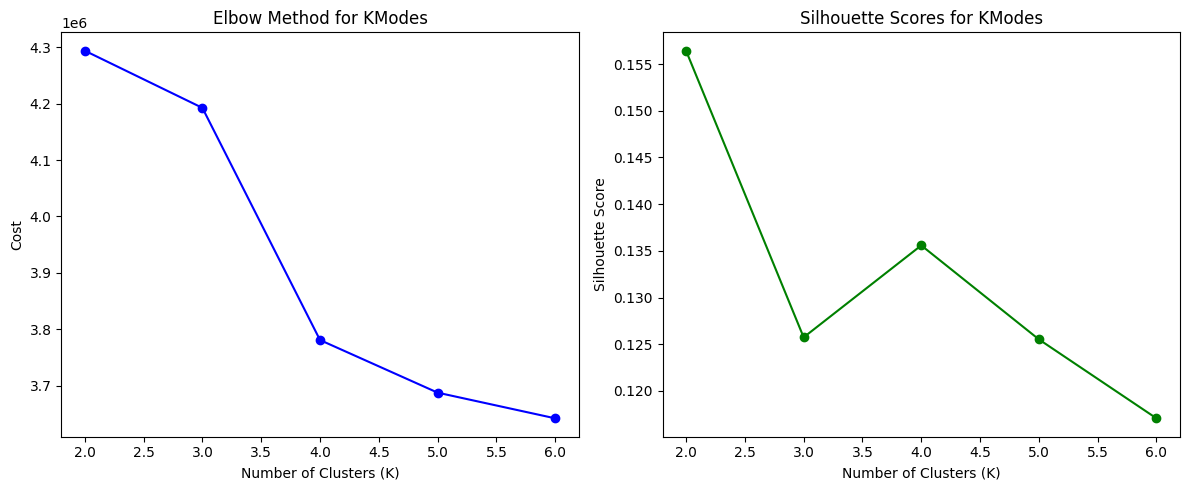

Stability K=2 mean_pairwise_ARI=1.0000 pairwise=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Stability K=6 mean_pairwise_ARI=1.0000 pairwise=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from collections import Counter

# ---------- CONFIG ----------
# original VARIABLES list (will be mapped to encoded names)
VARIABLES = ['AGR_ALFAB','AGR_SEXO','AGR_TRABAJA','VIC_ALFAB','VIC_SEXO',
       'VIC_OTRAS_VICTIMAS','VIOLENCIA_FISICA','VIC_ES_INDIGENA',
       'VIC_TRABAJA','VIOLENCIA_PSICOLOGICA','VIOLENCIA_PATRIMONIAL',
       'VIC_DEDICA','OTROS_AGRESORES','AGR_DEDICA','CANTIDAD_HIJOS',
       'VIC_EST_CIV','VIC_REL_AGR','VIOLENCIA_SEXUAL','VIC_GRUPET',
       'VIC_DISC','VIC_NIV_ESCOLARIDAD','AGR_NACIONAL',
       'AGR_OCUP_GRUPO','VIC_NACIONAL','AGR_EST_CIV','AGR_GRUPET',
       'VIC_OFICIO','AGR_ES_INDIGENA','AGR_NIV_ESCOLARIDAD',
       'VIC_OCUP_GRUPO','AGR_OFICIO']

# Expect encoded columns named like "VAR_ENC"
ENCODED_VARS = [v + '_ENC' for v in VARIABLES]

RANDOM_STATE = 42
SUBSAMPLE_FRAC = 0.25
COARSE_KS = range(2, 11, 2)
FINE_KS = range(2, 7)
COARSE_N_INIT = 1
COARSE_MAX_ITER = 50
REFINE_N_INIT = 3
REFINE_MAX_ITER = 200
N_JOBS = -1  # set to 1 if environment forbids multiprocessing

# ---------- Sanity checks ----------
assert 'df' in globals(), "DataFrame 'df' must be defined"
missing = [c for c in ENCODED_VARS if c not in df.columns]
if missing:
    raise ValueError(f"The following expected encoded columns are missing from df: {missing}")

# Use only the encoded variables (assumed already integer-coded)
X = df[ENCODED_VARS].copy()
# Ensure integer numpy array for kmodes
X_np = X.values.astype(int)

# ---------- Utility: run kmodes and compute metrics ----------
def run_kmodes(X_array, k, init='Cao', n_init=1, max_iter=100, n_jobs=1, random_state=None):
    km = KModes(n_clusters=k, init=init, n_init=n_init, max_iter=max_iter,
                verbose=0, n_jobs=n_jobs, random_state=random_state)
    labels = km.fit_predict(X_array)
    cost = km.cost_
    return km, labels, cost

# ---------- 1) Coarse scan on subsample ----------
X_sub, _ = train_test_split(X_np, test_size=1-SUBSAMPLE_FRAC, random_state=RANDOM_STATE)

coarse_results = []
for k in COARSE_KS:
    km, labels_sub, cost = run_kmodes(
        X_sub, k,
        init='random', n_init=COARSE_N_INIT, max_iter=COARSE_MAX_ITER,
        n_jobs=N_JOBS, random_state=RANDOM_STATE
    )
    sil = silhouette_score(X_sub, labels_sub, metric='hamming')
    coarse_results.append({'k': k, 'cost': cost, 'silhouette': sil})
    print(f"Coarse K={k}  cost={cost:.2f}  silhouette={sil:.4f}")

# Pick top candidate Ks by silhouette on subsample
coarse_sorted = sorted(coarse_results, key=lambda r: r['silhouette'], reverse=True)
best_candidates = [r['k'] for r in coarse_sorted[:2]]
print("Refining Ks:", best_candidates)

# ---------- 2) Refinement on full data for selected Ks ----------
detailed = {}
for k in best_candidates:
    km, labels_full, cost_full = run_kmodes(
        X_np, k,
        init='Cao', n_init=REFINE_N_INIT, max_iter=REFINE_MAX_ITER,
        n_jobs=N_JOBS, random_state=RANDOM_STATE
    )
    # compute silhouette on full data or a sample if huge
    try:
        sil_full = silhouette_score(X_np, labels_full, metric='hamming',
                                    sample_size=min(10000, len(X_np)), random_state=RANDOM_STATE)
    except TypeError:
        sil_full = silhouette_score(X_np, labels_full, metric='hamming')
    counts = Counter(labels_full)
    detailed[k] = {'km': km, 'labels': labels_full, 'cost': cost_full, 'silhouette': sil_full, 'counts': counts}
    print(f"Refined K={k}  cost={cost_full:.2f}  silhouette={sil_full:.4f}  counts={dict(counts)}")

# ---------- 3) Optional: fast full K diagnostic (lowered settings) ----------
K = list(FINE_KS)
costs = []
silhouette_scores = []
for k in K:
    km, labels, cost = run_kmodes(X_np, k, init='Cao', n_init=1, max_iter=80, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    costs.append(cost)
    try:
        sil = silhouette_score(X_np, labels, metric='hamming', sample_size=min(10000, len(X_np)), random_state=RANDOM_STATE)
    except TypeError:
        sil = silhouette_score(X_np, labels, metric='hamming')
    silhouette_scores.append(sil)
    print(f"Full-scan K={k}  cost={cost:.2f}  silhouette_sampled={sil:.4f}")

# ---------- 4) Plot Elbow and Silhouette ----------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, costs, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost')
plt.title('Elbow Method for KModes')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for KModes')

plt.tight_layout()
plt.show()

# ---------- 5) Stability check (optional) ----------
# Run multiple short kmodes fits and compare cluster assignments with Adjusted Rand Index
def stability_check(X_array, k, runs=5):
    labels_runs = []
    for r in range(runs):
        _, labels_r, _ = run_kmodes(X_array, k, init='Cao', n_init=1, max_iter=100, n_jobs=1, random_state=RANDOM_STATE + r)
        labels_runs.append(labels_r)
    # pairwise ARI average
    pairwise = []
    for i in range(len(labels_runs)):
        for j in range(i+1, len(labels_runs)):
            pairwise.append(adjusted_rand_score(labels_runs[i], labels_runs[j]))
    return np.mean(pairwise), pairwise

for k in best_candidates:
    mean_ari, pairwise = stability_check(X_np, k, runs=4)
    print(f"Stability K={k} mean_pairwise_ARI={mean_ari:.4f} pairwise={pairwise}")


In [7]:
import joblib

# Assume `best_k` is your chosen K and `detailed` holds the results
best_k = max(detailed, key=lambda k: detailed[k]['silhouette'])
best_km = detailed[best_k]['km']

# Dump the KModes instance
joblib.dump(best_km, f'kmodes_k{best_k}_model.pkl')


['kmodes_k2_model.pkl']

In [8]:
joblib.dump(detailed, 'kmodes_detailed_stats.pkl')


['kmodes_detailed_stats.pkl']

In [9]:
# reload model if needed
km = joblib.load(f'kmodes_k{best_k}_model.pkl')

# predict on full data to get labels
cluster_labels = km.predict(X_np)

# attach to original df
df['cluster'] = cluster_labels

# save augmented DataFrame
df.to_csv('df_with_clusters.csv', index=False)
